## 소셜군집에 대한 피쳐 선택 및 예측 모델 생성하기

#### 1. 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from matplotlib import font_manager, rc, cm
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#### 2. 데이터 불러오기 / 전처리

(1) sns 검색데이터 / 구매 데이터 / 날씨 데이터 / 군집 기준 데이터 불러오기

In [2]:
beatuy_label = pd.read_csv('beauty_label_6.csv')
food_label = pd.read_csv('food_label_7.csv')
electric_label = pd.read_csv('elec_label_5.csv')

sns_data = pd.read_csv('sns_data 이상치 대체.csv')
climate_data = pd.read_csv('climate_data_date_스케일링전.csv')

input_file = r'C:\Users\gby1349\python\공모전\군집화 이후' 

all_file_list = glob.glob(os.path.join(input_file, 'buy_data*'))
all_data = [] 

for file in all_file_list:
    df = pd.read_csv(file) 
    all_data.append(df)
    
buy_data = pd.concat(all_data, axis=0, ignore_index=True)

(2) 날씨 데이터 전처리
- 카테고리 변수 인코딩 : 강수계급 / 바람계급 / 구릅 계급 인코딩
- 주 / 날짜 정보 제거 

In [3]:
climate_data = climate_data.set_index('date')

# 주/날짜 정보 제거 
del climate_data['week'], climate_data['day']

# 카테고리 변수 인코딩
climate_data['강수계급'] = climate_data['강수계급'].agg(lambda x: 0 if x == '무강수' else 1 if x == '0.1mm이상 1mm미만' 
                         else 2 if x == '1mm이상 10mm미만' else 3 if x == '10mm이상 30mm미만' else 4)

climate_data['바람계급'] = climate_data['바람계급'].agg(lambda x: 0 if x == '0.5m/s이상 3.4m/s미만' else 1)

climate_data['구름계급'] = climate_data['구름계급'].agg(lambda x : 0 if x == '맑음' else 1 if x == '구름조금' 
                                                else 2 if x == '구름많음' else 3)

(3) 구매 데이터와 SNS 데이터 merge
- 구매 데이터와 SNS 데이터 merge를 위한 전처리: buy_data(num) / sns_data(index) 제거
- 클러스터링 간의 나눈(대분류 안에 소분류 상품들에 대한 군집) 군집번호 merge

In [4]:
# buy_data / sns_Data 불필요한 정보 제거 
buy_data = buy_data.iloc[:,1:]
sns_data = sns_data.iloc[:,2:]

In [5]:
# 군집 번호를 결합하기 위해서 전처리(칼럼명 변경)
beatuy_label = beatuy_label.rename(columns = {'소분류' : 'sm_cat'})
food_label = food_label.rename(columns = {'소분류' : 'sm_cat'})
electric_label = electric_label.rename(columns = {'소분류' : 'sm_cat'})

# merge를 위해 소분류 별 대응 군집 번호 대한 데이터프레임 생성
label =  pd.concat([beatuy_label, food_label, electric_label], axis = 0)  

In [6]:
# 구매 데이터 / sns 데이터 / 군집 데이터 merge 형성
new = pd.merge(buy_data, sns_data, on = ['date','big_cat','sm_cat'], how = 'inner')
new_label = pd.merge(new, label, on = ['sm_cat'], how= 'inner')

(4) SNS 데이터 활용하기 위해 
- 기존 일일 데이터에서 sns 데이터를 성별 / 나이별에 대응하기 SNS 검색량에 대한 나이대/성별 변환 

In [7]:
cnt_ratio = pd.read_excel('cnt비율.xlsx',sheet_name = '비율_정리')
new_label = pd.merge(new_label, cnt_ratio, on =['sex','age','big_cat'], how ='left')

In [8]:
new_label['cnt']  = new_label['cnt'] * new_label['cnt_ratio']

In [9]:
new_label

,date,sex,age,big_cat,sm_cat,qty,cnt,labels,cnt_ratio
0,2018-01-01,F,20,식품,가공란,37.0,0.067079,5,0.139469
1,2018-01-01,F,30,식품,가공란,16.0,0.124727,5,0.259327
2,2018-01-01,F,40,식품,가공란,9.0,0.093214,5,0.193807
3,2018-01-01,F,50,식품,가공란,3.0,0.034371,5,0.071462
4,2018-01-01,M,20,식품,가공란,13.0,0.030769,5,0.063975
...,...,...,...,...,...,...,...,...,...
2056894,2019-11-20,M,20,뷰티,남성향수,1.0,0.562129,1,0.047010
2056895,2019-12-08,M,20,뷰티,남성향수,1.0,0.702726,1,0.047010
2056896,2019-12-16,M,20,뷰티,남성향수,1.0,0.490612,1,0.047010
2056897,2019-12-25,M,40,뷰티,남성향수,1.0,0.599433,1,0.052327


(5) 해당 군집에 따른 데이터 추출

query문에 대분류(식품 / 뷰티 / 냉난방가전 기입), 군집 번호(대분류 내) 입력

나이대 정보 인코딩으로 활용하기 위해서 전처리

예) 소셜 군집 中 식품 클러스터링 0, 배추김치

In [10]:
example = new_label.query('big_cat == "식품" and labels ==0 and sm_cat == "배추김치"')
example['age'] = example['age'].agg(lambda x: str(x) + "대")
example = example[['qty','date','sex','age','sm_cat','cnt']] # sm_cat: query문이 제대로 추출했는지 확인용 

example['qty'] = example['qty'].fillna(0);example.head()

,qty,date,sex,age,sm_cat,cnt
777444,8.0,2018-01-01,F,20대,배추김치,1.602787
777445,28.0,2018-01-01,F,30대,배추김치,2.980212
777446,30.0,2018-01-01,F,40대,배추김치,2.227251
777447,28.0,2018-01-01,F,50대,배추김치,0.821247
777448,3.0,2018-01-01,F,60대,배추김치,0.240578


In [11]:
del example['sm_cat'] # 확인 후 소분류명 삭제 

In [12]:
# 해당 군집과 대응 되는 날씨 변수명 선택 / 계절 군집도 고려(오이/가지는 여름으로 선택)
climate_date_00 = climate_data[['최저기온','최고기온','rain','최대풍속','평균상대습도',
                                '평균현지기압','평균증기압','합계일조시간','SO2','CO','O3','NO2','PM10','PM25',
                                '최고자외선지수','threerain','tenrain','weekend','실효습도','기온편차']]

In [13]:
# 날씨 데이터 와 최종 데이터 합치기 
climate_date_00 = climate_date_00.reset_index()
example_food_00 = pd.merge(example, climate_date_00, on = 'date', how= 'left')

In [14]:
#특정 계쩔에 대한 데이터 예측을 위해 월 컬럼 생성 후 데이터 정제 / 이후 울 데이터 삭제
example_food_00['date'] = pd.to_datetime(example_food_00['date'])
example_food_00['월'] = example_food_00['date'].dt.month

# 필요한 계절 추출
food_00_category = example_food_00.query('월 == 7 or 월 ==8 or 월 == 9')
del food_00_category['월']

# 최종 날짜 데이터를 index화
food_00_category= food_00_category.set_index('date')

#### 3. 데이터 split 후 모델 학습 
- Auto ML(Pycrat)를 활용해 모델 비교 후 모델 선택 
- train/test 나눌 때 test_size = 20%, 셔플 및 시드값은 0으로 고정
- 학습하는 과정에 용의성을 위해서 x_train과 그에 대응되는 y값(y_train / 날짜별(연령 및 성별) 판매량 값

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(food_00_category.iloc[:,1:], food_00_category.iloc[:,0], 
                                                    test_size=0.2, shuffle=True, random_state=0)
train = pd.concat([x_train, y_train], axis = 1)

####  (1) 모델 생성 후 성능 비교 
- 가, Categroy 변수(나이 / 성별 / 주말 여부)에 대해 모델 자동 인코딩 
- 나. 극단값에 대해서는 정규화(Zscore : 정규화)
- 다. fold 기준: 3회 검증 및 시계열로 인식
- 라. 시드값은 0으로 고정
- 마. null값은 평균으로 대체(기본 데이터가 null값이 없으므로 의미 X)

In [16]:
from pycaret.regression import *
reg = setup(data=train,
            target='qty',
            numeric_imputation = 'mean',
            normalize = True,
            normalize_method = 'zscore',
            categorical_features = ['age','sex','weekend'],
            silent= True,
            fold_strategy = 'timeseries',
            fold = 3,
            session_id = 0)

,Description,Value
0,session_id,0
1,Target,qty
2,Original Data,"(1471, 24)"
3,Missing Values,False
4,Numeric Features,20
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1029, 27)"


- 모델 성능 비교(R2를 기준) 

In [17]:
best_3_d = compare_models(sort = 'R2', n_select = 3)
print(best_3_d)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,12.7259,331.8973,18.1155,0.8224,0.4551,0.4861,0.9533
lightgbm,Light Gradient Boosting Machine,13.7159,369.0753,19.1799,0.8047,0.5141,0.5302,0.2267
gbr,Gradient Boosting Regressor,13.5881,391.3890,19.7141,0.7914,0.4816,0.5202,0.0767
xgboost,Extreme Gradient Boosting,15.0244,505.1320,22.4385,0.7332,0.4729,0.5023,0.6800
rf,Random Forest Regressor,15.8665,541.3923,23.2607,0.7148,0.5116,0.5764,0.0900
br,Bayesian Ridge,18.1138,576.5426,24.0087,0.6982,0.6260,0.8071,0.0067
ridge,Ridge Regression,18.3443,582.4105,24.1305,0.6947,0.6282,0.8399,0.7933
lr,Linear Regression,18.6307,594.3709,24.3745,0.6876,0.6439,0.8738,1.2700
huber,Huber Regressor,17.1982,598.4062,24.4610,0.6871,0.5717,0.6963,0.0167
et,Extra Trees Regressor,16.5369,593.9128,24.3030,0.6837,0.5295,0.6044,0.0667


[<catboost.core.CatBoostRegressor object at 0x000002459120A7C0>, LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_chang

#### (2)  모델 생성 및 튜닝 (단일 모델 3개 / 배깅 모델 3개 / 부스팅 3개 / 블렌딩 3개)
- R을 기준으로 상위 모델 선정 
- 단 다른 5개의 성능 지표 비교해서 결정(Gradient Boosting Regressor 대신 Extra Trees Regressor 모델 선정 : 다른 성능 지표 향상)

In [18]:
tuned_models = []

- 가. 단일 모델 생성

In [19]:
### CatBoost Regressor 튜닝(상위 모델 1번)
model_01 = create_model('catboost')# 상위 3개

model_01 = tune_model(model_01, fold= 3, n_iter = 100, optimize = 'R2', verbose = True, choose_better = True)
tuned_models.append(model_01)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,14.2188,413.0271,20.3231,0.7509,0.5150,0.5850
1,12.6744,329.0982,18.1411,0.8393,0.4171,0.4056
2,10.8939,261.8737,16.1825,0.8742,0.4070,0.3892
Mean,12.5957,334.6663,18.2155,0.8215,0.4464,0.4600
SD,1.3586,61.8336,1.6912,0.0519,0.0487,0.0887


In [20]:
###lightgbm 튜닝
model_02 = create_model('lightgbm') ## 상위 3개

model_02 = tune_model(model_02, fold= 3, n_iter = 100, optimize = 'R2', verbose = True, choose_better = True)
tuned_models.append(model_02)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,14.9383,409.1026,20.2263,0.7532,0.5504,0.6690
1,13.8271,359.9666,18.9728,0.8242,0.4377,0.4455
2,11.5028,294.0679,17.1484,0.8587,0.4592,0.4588
Mean,13.4228,354.3790,18.7825,0.8121,0.4824,0.5244
SD,1.4314,47.1286,1.2637,0.0439,0.0489,0.1024


In [21]:
model_03 = create_model('gbr')

model_03 = tune_model(model_03, fold= 3, n_iter = 100, optimize = 'R2', verbose = True, choose_better = True)
tuned_models.append(model_03)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,15.9847,477.0392,21.8412,0.7123,0.6738,0.8096
1,13.7477,353.1950,18.7935,0.8276,0.5063,0.4979
2,12.1201,279.1007,16.7063,0.8659,0.5086,0.5618
Mean,13.9508,369.7783,19.1137,0.8019,0.5629,0.6231
SD,1.5842,81.6544,2.1085,0.0653,0.0784,0.1344


- 나. 앙상블 모델 생성: 배깅

In [22]:
prediction_models = []

In [23]:
bag_01_15 = ensemble_model(model_01, n_estimators = 15, fold=3, optimize = 'R2')
prediction_models.append(bag_01_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,15.2597,453.2655,21.2900,0.7266,0.5421,0.6783
1,13.5808,379.3824,19.4777,0.8148,0.4229,0.4341
2,11.5066,282.8499,16.8181,0.8641,0.4261,0.4284
Mean,13.4491,371.8326,19.1953,0.8018,0.4637,0.5136
SD,1.5350,69.7764,1.8365,0.0569,0.0555,0.1165


In [24]:
bag_02_15 = ensemble_model(model_02, n_estimators = 15, fold=3, optimize = 'R2')
prediction_models.append(bag_02_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,14.6498,420.0925,20.4962,0.7466,0.5177,0.6151
1,13.6813,384.6818,19.6133,0.8122,0.4341,0.4375
2,11.4162,293.0687,17.1192,0.8592,0.4135,0.4264
Mean,13.2491,365.9477,19.0762,0.8060,0.4551,0.4930
SD,1.3550,53.5225,1.4300,0.0462,0.0450,0.0865


In [25]:
bag_03_15 = ensemble_model(model_03, n_estimators = 15, fold=3, optimize = 'R2')
prediction_models.append(bag_03_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,14.9805,436.7105,20.8976,0.7366,0.5742,0.6804
1,13.5215,347.9177,18.6526,0.8301,0.4815,0.4794
2,11.5944,275.6290,16.6021,0.8676,0.4491,0.4815
Mean,13.3654,353.4191,18.7174,0.8114,0.5016,0.5471
SD,1.3868,65.8762,1.7542,0.0551,0.0530,0.0943


- 나. 앙상블 모델 생성: 배깅

In [26]:
boo_01 = ensemble_model(model_01, method = 'Boosting', fold=3, optimize='R2')
prediction_models.append(boo_01)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,16.5812,459.3022,21.4313,0.7230,0.6148,0.8511
1,13.5043,358.0583,18.9224,0.8252,0.4433,0.4495
2,11.4384,270.1071,16.4349,0.8702,0.4212,0.4179
Mean,13.8413,362.4892,18.9296,0.8061,0.4931,0.5728
SD,2.1130,77.3021,2.0398,0.0616,0.0865,0.1972


In [27]:
boo_02 = ensemble_model(model_02, method = 'Boosting', fold=3, optimize='R2')
prediction_models.append(boo_02)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,15.8511,462.3199,21.5016,0.7211,0.5665,0.7235
1,14.3103,398.5066,19.9626,0.8054,0.4485,0.4748
2,11.8208,300.5003,17.3349,0.8556,0.4160,0.4280
Mean,13.9940,387.1089,19.5997,0.7941,0.4770,0.5421
SD,1.6605,66.5524,1.7203,0.0555,0.0647,0.1297


In [28]:
boo_03 = ensemble_model(model_03, method = 'Boosting', fold=3, optimize='R2')
prediction_models.append(boo_03)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,15.9470,444.8699,21.0919,0.7317,0.5732,0.7147
1,13.7959,362.8485,19.0486,0.8228,0.4815,0.4772
2,12.0049,287.8647,16.9666,0.8617,0.4952,0.5017
Mean,13.9159,365.1944,19.0357,0.8054,0.5166,0.5645
SD,1.6116,64.1185,1.6842,0.0545,0.0404,0.1066


- 블렌딩

In [29]:
blend_3_soft = blend_models(estimator_list=[model_01, model_02, model_03], fold=3, optimize='R2')
prediction_models.append(blend_3_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,13.9221,379.9295,19.4918,0.7708,0.5513,0.6412
1,12.8090,318.0046,17.8327,0.8447,0.4583,0.4261
2,10.8650,247.5432,15.7335,0.8811,0.4275,0.4432
Mean,12.5320,315.1591,17.6860,0.8322,0.4790,0.5035
SD,1.2633,54.0839,1.5378,0.0459,0.0526,0.0976


In [30]:
for model in tuned_models:
    print(model.__class__.__name__)
    display(predict_model(model))

CatBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,11.7269,302.4259,17.3904,0.8657,0.4232,0.3417


,cnt,최저기온,최고기온,rain,최대풍속,평균상대습도,평균현지기압,평균증기압,합계일조시간,SO2,...,기온편차,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.903654,1.340351,1.617177,-0.774686,0.189717,-0.976345,-0.341217,1.102502,1.184159,0.809130,...,-0.626329,1.0,0.0,0.0,0.0,1.0,0.0,0.0,28.0,33.721136
1,0.266154,-0.617252,-0.095062,-0.753682,-0.358932,-0.641021,-0.166872,-0.746608,1.199282,0.216253,...,-1.013318,1.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,21.452098
2,-0.715664,0.685809,1.159015,-0.795691,-0.658413,-0.442950,0.406931,0.700844,1.646797,1.843640,...,0.087995,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,8.389319
3,0.618978,0.186405,0.400052,-0.735959,-0.416259,-0.431897,0.140263,0.105065,0.421433,-0.622294,...,0.001384,1.0,0.0,1.0,0.0,0.0,0.0,1.0,34.0,57.067453
4,-1.151214,1.238088,1.748405,-0.746886,-0.475321,-0.423830,-0.494527,1.351591,1.141515,1.888010,...,-0.549040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,7.363398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.452564,1.108516,1.546166,-0.790439,-0.449334,-0.640854,-0.370937,1.108055,1.459520,1.878626,...,-0.641564,0.0,1.0,0.0,0.0,0.0,0.0,1.0,13.0,16.355177
438,-1.160852,-1.493962,-0.770774,-0.643684,0.072774,-0.470135,0.950533,-1.372371,0.790917,-0.457167,...,-0.013406,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,3.099111
439,-0.936640,-0.094588,-0.552667,0.611142,-0.645321,0.911307,-0.354397,-0.081652,-0.821507,-0.373258,...,-1.254587,0.0,0.0,0.0,0.0,0.0,1.0,1.0,55.0,54.138496
440,-0.788046,-0.014310,0.002020,-0.795054,-0.584084,-0.504087,-0.111517,-0.299144,-0.035046,-0.085407,...,-0.857572,1.0,0.0,0.0,0.0,1.0,0.0,1.0,46.0,37.151279


LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,12.2406,327.0040,18.0833,0.8548,0.4000,0.3674


,cnt,최저기온,최고기온,rain,최대풍속,평균상대습도,평균현지기압,평균증기압,합계일조시간,SO2,...,기온편차,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.903654,1.340351,1.617177,-0.774686,0.189717,-0.976345,-0.341217,1.102502,1.184159,0.809130,...,-0.626329,1.0,0.0,0.0,0.0,1.0,0.0,0.0,28.0,30.274855
1,0.266154,-0.617252,-0.095062,-0.753682,-0.358932,-0.641021,-0.166872,-0.746608,1.199282,0.216253,...,-1.013318,1.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,23.775570
2,-0.715664,0.685809,1.159015,-0.795691,-0.658413,-0.442950,0.406931,0.700844,1.646797,1.843640,...,0.087995,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,11.517277
3,0.618978,0.186405,0.400052,-0.735959,-0.416259,-0.431897,0.140263,0.105065,0.421433,-0.622294,...,0.001384,1.0,0.0,1.0,0.0,0.0,0.0,1.0,34.0,47.541745
4,-1.151214,1.238088,1.748405,-0.746886,-0.475321,-0.423830,-0.494527,1.351591,1.141515,1.888010,...,-0.549040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,5.900587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.452564,1.108516,1.546166,-0.790439,-0.449334,-0.640854,-0.370937,1.108055,1.459520,1.878626,...,-0.641564,0.0,1.0,0.0,0.0,0.0,0.0,1.0,13.0,23.030062
438,-1.160852,-1.493962,-0.770774,-0.643684,0.072774,-0.470135,0.950533,-1.372371,0.790917,-0.457167,...,-0.013406,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,2.222769
439,-0.936640,-0.094588,-0.552667,0.611142,-0.645321,0.911307,-0.354397,-0.081652,-0.821507,-0.373258,...,-1.254587,0.0,0.0,0.0,0.0,0.0,1.0,1.0,55.0,56.116140
440,-0.788046,-0.014310,0.002020,-0.795054,-0.584084,-0.504087,-0.111517,-0.299144,-0.035046,-0.085407,...,-0.857572,1.0,0.0,0.0,0.0,1.0,0.0,1.0,46.0,43.276819


GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,13.7587,375.2820,19.3722,0.8334,0.5201,0.4835


,cnt,최저기온,최고기온,rain,최대풍속,평균상대습도,평균현지기압,평균증기압,합계일조시간,SO2,...,기온편차,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.903654,1.340351,1.617177,-0.774686,0.189717,-0.976345,-0.341217,1.102502,1.184159,0.809130,...,-0.626329,1.0,0.0,0.0,0.0,1.0,0.0,0.0,28.0,26.513941
1,0.266154,-0.617252,-0.095062,-0.753682,-0.358932,-0.641021,-0.166872,-0.746608,1.199282,0.216253,...,-1.013318,1.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,21.125846
2,-0.715664,0.685809,1.159015,-0.795691,-0.658413,-0.442950,0.406931,0.700844,1.646797,1.843640,...,0.087995,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,18.443713
3,0.618978,0.186405,0.400052,-0.735959,-0.416259,-0.431897,0.140263,0.105065,0.421433,-0.622294,...,0.001384,1.0,0.0,1.0,0.0,0.0,0.0,1.0,34.0,55.999518
4,-1.151214,1.238088,1.748405,-0.746886,-0.475321,-0.423830,-0.494527,1.351591,1.141515,1.888010,...,-0.549040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,10.075100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.452564,1.108516,1.546166,-0.790439,-0.449334,-0.640854,-0.370937,1.108055,1.459520,1.878626,...,-0.641564,0.0,1.0,0.0,0.0,0.0,0.0,1.0,13.0,20.300292
438,-1.160852,-1.493962,-0.770774,-0.643684,0.072774,-0.470135,0.950533,-1.372371,0.790917,-0.457167,...,-0.013406,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,3.582854
439,-0.936640,-0.094588,-0.552667,0.611142,-0.645321,0.911307,-0.354397,-0.081652,-0.821507,-0.373258,...,-1.254587,0.0,0.0,0.0,0.0,0.0,1.0,1.0,55.0,60.509060
440,-0.788046,-0.014310,0.002020,-0.795054,-0.584084,-0.504087,-0.111517,-0.299144,-0.035046,-0.085407,...,-0.857572,1.0,0.0,0.0,0.0,1.0,0.0,1.0,46.0,28.966862


In [31]:
for model in prediction_models:
    print(model.__class__.__name__)
    display(predict_model(model))

BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,12.2589,341.4323,18.4779,0.8484,0.4027,0.3391


,cnt,최저기온,최고기온,rain,최대풍속,평균상대습도,평균현지기압,평균증기압,합계일조시간,SO2,...,기온편차,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.903654,1.340351,1.617177,-0.774686,0.189717,-0.976345,-0.341217,1.102502,1.184159,0.809130,...,-0.626329,1.0,0.0,0.0,0.0,1.0,0.0,0.0,28.0,31.915012
1,0.266154,-0.617252,-0.095062,-0.753682,-0.358932,-0.641021,-0.166872,-0.746608,1.199282,0.216253,...,-1.013318,1.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,23.954305
2,-0.715664,0.685809,1.159015,-0.795691,-0.658413,-0.442950,0.406931,0.700844,1.646797,1.843640,...,0.087995,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,5.184699
3,0.618978,0.186405,0.400052,-0.735959,-0.416259,-0.431897,0.140263,0.105065,0.421433,-0.622294,...,0.001384,1.0,0.0,1.0,0.0,0.0,0.0,1.0,34.0,52.874914
4,-1.151214,1.238088,1.748405,-0.746886,-0.475321,-0.423830,-0.494527,1.351591,1.141515,1.888010,...,-0.549040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,8.748692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.452564,1.108516,1.546166,-0.790439,-0.449334,-0.640854,-0.370937,1.108055,1.459520,1.878626,...,-0.641564,0.0,1.0,0.0,0.0,0.0,0.0,1.0,13.0,15.773542
438,-1.160852,-1.493962,-0.770774,-0.643684,0.072774,-0.470135,0.950533,-1.372371,0.790917,-0.457167,...,-0.013406,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.907193
439,-0.936640,-0.094588,-0.552667,0.611142,-0.645321,0.911307,-0.354397,-0.081652,-0.821507,-0.373258,...,-1.254587,0.0,0.0,0.0,0.0,0.0,1.0,1.0,55.0,51.247509
440,-0.788046,-0.014310,0.002020,-0.795054,-0.584084,-0.504087,-0.111517,-0.299144,-0.035046,-0.085407,...,-0.857572,1.0,0.0,0.0,0.0,1.0,0.0,1.0,46.0,36.575331


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,12.2979,356.8952,18.8917,0.8415,0.3747,0.3294


,cnt,최저기온,최고기온,rain,최대풍속,평균상대습도,평균현지기압,평균증기압,합계일조시간,SO2,...,기온편차,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.903654,1.340351,1.617177,-0.774686,0.189717,-0.976345,-0.341217,1.102502,1.184159,0.809130,...,-0.626329,1.0,0.0,0.0,0.0,1.0,0.0,0.0,28.0,31.665116
1,0.266154,-0.617252,-0.095062,-0.753682,-0.358932,-0.641021,-0.166872,-0.746608,1.199282,0.216253,...,-1.013318,1.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,26.994677
2,-0.715664,0.685809,1.159015,-0.795691,-0.658413,-0.442950,0.406931,0.700844,1.646797,1.843640,...,0.087995,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,5.872792
3,0.618978,0.186405,0.400052,-0.735959,-0.416259,-0.431897,0.140263,0.105065,0.421433,-0.622294,...,0.001384,1.0,0.0,1.0,0.0,0.0,0.0,1.0,34.0,49.134714
4,-1.151214,1.238088,1.748405,-0.746886,-0.475321,-0.423830,-0.494527,1.351591,1.141515,1.888010,...,-0.549040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,9.417022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.452564,1.108516,1.546166,-0.790439,-0.449334,-0.640854,-0.370937,1.108055,1.459520,1.878626,...,-0.641564,0.0,1.0,0.0,0.0,0.0,0.0,1.0,13.0,19.306905
438,-1.160852,-1.493962,-0.770774,-0.643684,0.072774,-0.470135,0.950533,-1.372371,0.790917,-0.457167,...,-0.013406,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,4.961047
439,-0.936640,-0.094588,-0.552667,0.611142,-0.645321,0.911307,-0.354397,-0.081652,-0.821507,-0.373258,...,-1.254587,0.0,0.0,0.0,0.0,0.0,1.0,1.0,55.0,54.176341
440,-0.788046,-0.014310,0.002020,-0.795054,-0.584084,-0.504087,-0.111517,-0.299144,-0.035046,-0.085407,...,-0.857572,1.0,0.0,0.0,0.0,1.0,0.0,1.0,46.0,38.824236


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,12.9086,354.8043,18.8362,0.8425,0.4302,0.4197


,cnt,최저기온,최고기온,rain,최대풍속,평균상대습도,평균현지기압,평균증기압,합계일조시간,SO2,...,기온편차,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.903654,1.340351,1.617177,-0.774686,0.189717,-0.976345,-0.341217,1.102502,1.184159,0.809130,...,-0.626329,1.0,0.0,0.0,0.0,1.0,0.0,0.0,28.0,33.667405
1,0.266154,-0.617252,-0.095062,-0.753682,-0.358932,-0.641021,-0.166872,-0.746608,1.199282,0.216253,...,-1.013318,1.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,18.896200
2,-0.715664,0.685809,1.159015,-0.795691,-0.658413,-0.442950,0.406931,0.700844,1.646797,1.843640,...,0.087995,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,7.084162
3,0.618978,0.186405,0.400052,-0.735959,-0.416259,-0.431897,0.140263,0.105065,0.421433,-0.622294,...,0.001384,1.0,0.0,1.0,0.0,0.0,0.0,1.0,34.0,53.292186
4,-1.151214,1.238088,1.748405,-0.746886,-0.475321,-0.423830,-0.494527,1.351591,1.141515,1.888010,...,-0.549040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,7.262321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.452564,1.108516,1.546166,-0.790439,-0.449334,-0.640854,-0.370937,1.108055,1.459520,1.878626,...,-0.641564,0.0,1.0,0.0,0.0,0.0,0.0,1.0,13.0,18.666316
438,-1.160852,-1.493962,-0.770774,-0.643684,0.072774,-0.470135,0.950533,-1.372371,0.790917,-0.457167,...,-0.013406,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.795588
439,-0.936640,-0.094588,-0.552667,0.611142,-0.645321,0.911307,-0.354397,-0.081652,-0.821507,-0.373258,...,-1.254587,0.0,0.0,0.0,0.0,0.0,1.0,1.0,55.0,52.667558
440,-0.788046,-0.014310,0.002020,-0.795054,-0.584084,-0.504087,-0.111517,-0.299144,-0.035046,-0.085407,...,-0.857572,1.0,0.0,0.0,0.0,1.0,0.0,1.0,46.0,36.093017


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,12.4211,322.6510,17.9625,0.8567,0.4274,0.3580


,cnt,최저기온,최고기온,rain,최대풍속,평균상대습도,평균현지기압,평균증기압,합계일조시간,SO2,...,기온편차,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.903654,1.340351,1.617177,-0.774686,0.189717,-0.976345,-0.341217,1.102502,1.184159,0.809130,...,-0.626329,1.0,0.0,0.0,0.0,1.0,0.0,0.0,28.0,29.739695
1,0.266154,-0.617252,-0.095062,-0.753682,-0.358932,-0.641021,-0.166872,-0.746608,1.199282,0.216253,...,-1.013318,1.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,24.034732
2,-0.715664,0.685809,1.159015,-0.795691,-0.658413,-0.442950,0.406931,0.700844,1.646797,1.843640,...,0.087995,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,6.149285
3,0.618978,0.186405,0.400052,-0.735959,-0.416259,-0.431897,0.140263,0.105065,0.421433,-0.622294,...,0.001384,1.0,0.0,1.0,0.0,0.0,0.0,1.0,34.0,55.936327
4,-1.151214,1.238088,1.748405,-0.746886,-0.475321,-0.423830,-0.494527,1.351591,1.141515,1.888010,...,-0.549040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,7.512347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.452564,1.108516,1.546166,-0.790439,-0.449334,-0.640854,-0.370937,1.108055,1.459520,1.878626,...,-0.641564,0.0,1.0,0.0,0.0,0.0,0.0,1.0,13.0,15.129940
438,-1.160852,-1.493962,-0.770774,-0.643684,0.072774,-0.470135,0.950533,-1.372371,0.790917,-0.457167,...,-0.013406,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.211762
439,-0.936640,-0.094588,-0.552667,0.611142,-0.645321,0.911307,-0.354397,-0.081652,-0.821507,-0.373258,...,-1.254587,0.0,0.0,0.0,0.0,0.0,1.0,1.0,55.0,51.954728
440,-0.788046,-0.014310,0.002020,-0.795054,-0.584084,-0.504087,-0.111517,-0.299144,-0.035046,-0.085407,...,-0.857572,1.0,0.0,0.0,0.0,1.0,0.0,1.0,46.0,30.935902


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,12.4482,351.5540,18.7498,0.8439,0.3985,0.3418


,cnt,최저기온,최고기온,rain,최대풍속,평균상대습도,평균현지기압,평균증기압,합계일조시간,SO2,...,기온편차,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.903654,1.340351,1.617177,-0.774686,0.189717,-0.976345,-0.341217,1.102502,1.184159,0.809130,...,-0.626329,1.0,0.0,0.0,0.0,1.0,0.0,0.0,28.0,34.214407
1,0.266154,-0.617252,-0.095062,-0.753682,-0.358932,-0.641021,-0.166872,-0.746608,1.199282,0.216253,...,-1.013318,1.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,28.208068
2,-0.715664,0.685809,1.159015,-0.795691,-0.658413,-0.442950,0.406931,0.700844,1.646797,1.843640,...,0.087995,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,3.605307
3,0.618978,0.186405,0.400052,-0.735959,-0.416259,-0.431897,0.140263,0.105065,0.421433,-0.622294,...,0.001384,1.0,0.0,1.0,0.0,0.0,0.0,1.0,34.0,52.485032
4,-1.151214,1.238088,1.748405,-0.746886,-0.475321,-0.423830,-0.494527,1.351591,1.141515,1.888010,...,-0.549040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,10.385975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.452564,1.108516,1.546166,-0.790439,-0.449334,-0.640854,-0.370937,1.108055,1.459520,1.878626,...,-0.641564,0.0,1.0,0.0,0.0,0.0,0.0,1.0,13.0,17.704579
438,-1.160852,-1.493962,-0.770774,-0.643684,0.072774,-0.470135,0.950533,-1.372371,0.790917,-0.457167,...,-0.013406,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,2.915652
439,-0.936640,-0.094588,-0.552667,0.611142,-0.645321,0.911307,-0.354397,-0.081652,-0.821507,-0.373258,...,-1.254587,0.0,0.0,0.0,0.0,0.0,1.0,1.0,55.0,57.578618
440,-0.788046,-0.014310,0.002020,-0.795054,-0.584084,-0.504087,-0.111517,-0.299144,-0.035046,-0.085407,...,-0.857572,1.0,0.0,0.0,0.0,1.0,0.0,1.0,46.0,47.376876


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,13.0226,347.9043,18.6522,0.8455,0.4630,0.4282


,cnt,최저기온,최고기온,rain,최대풍속,평균상대습도,평균현지기압,평균증기압,합계일조시간,SO2,...,기온편차,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.903654,1.340351,1.617177,-0.774686,0.189717,-0.976345,-0.341217,1.102502,1.184159,0.809130,...,-0.626329,1.0,0.0,0.0,0.0,1.0,0.0,0.0,28.0,30.440295
1,0.266154,-0.617252,-0.095062,-0.753682,-0.358932,-0.641021,-0.166872,-0.746608,1.199282,0.216253,...,-1.013318,1.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,21.018475
2,-0.715664,0.685809,1.159015,-0.795691,-0.658413,-0.442950,0.406931,0.700844,1.646797,1.843640,...,0.087995,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,5.741567
3,0.618978,0.186405,0.400052,-0.735959,-0.416259,-0.431897,0.140263,0.105065,0.421433,-0.622294,...,0.001384,1.0,0.0,1.0,0.0,0.0,0.0,1.0,34.0,57.338331
4,-1.151214,1.238088,1.748405,-0.746886,-0.475321,-0.423830,-0.494527,1.351591,1.141515,1.888010,...,-0.549040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,9.100582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.452564,1.108516,1.546166,-0.790439,-0.449334,-0.640854,-0.370937,1.108055,1.459520,1.878626,...,-0.641564,0.0,1.0,0.0,0.0,0.0,0.0,1.0,13.0,12.229255
438,-1.160852,-1.493962,-0.770774,-0.643684,0.072774,-0.470135,0.950533,-1.372371,0.790917,-0.457167,...,-0.013406,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,2.535864
439,-0.936640,-0.094588,-0.552667,0.611142,-0.645321,0.911307,-0.354397,-0.081652,-0.821507,-0.373258,...,-1.254587,0.0,0.0,0.0,0.0,0.0,1.0,1.0,55.0,52.489474
440,-0.788046,-0.014310,0.002020,-0.795054,-0.584084,-0.504087,-0.111517,-0.299144,-0.035046,-0.085407,...,-0.857572,1.0,0.0,0.0,0.0,1.0,0.0,1.0,46.0,33.554227


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,12.1299,309.6910,17.5980,0.8625,0.4393,0.3784


,cnt,최저기온,최고기온,rain,최대풍속,평균상대습도,평균현지기압,평균증기압,합계일조시간,SO2,...,기온편차,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.903654,1.340351,1.617177,-0.774686,0.189717,-0.976345,-0.341217,1.102502,1.184159,0.809130,...,-0.626329,1.0,0.0,0.0,0.0,1.0,0.0,0.0,28.0,30.169977
1,0.266154,-0.617252,-0.095062,-0.753682,-0.358932,-0.641021,-0.166872,-0.746608,1.199282,0.216253,...,-1.013318,1.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,22.117838
2,-0.715664,0.685809,1.159015,-0.795691,-0.658413,-0.442950,0.406931,0.700844,1.646797,1.843640,...,0.087995,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,12.783436
3,0.618978,0.186405,0.400052,-0.735959,-0.416259,-0.431897,0.140263,0.105065,0.421433,-0.622294,...,0.001384,1.0,0.0,1.0,0.0,0.0,0.0,1.0,34.0,53.536239
4,-1.151214,1.238088,1.748405,-0.746886,-0.475321,-0.423830,-0.494527,1.351591,1.141515,1.888010,...,-0.549040,1.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,7.779695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.452564,1.108516,1.546166,-0.790439,-0.449334,-0.640854,-0.370937,1.108055,1.459520,1.878626,...,-0.641564,0.0,1.0,0.0,0.0,0.0,0.0,1.0,13.0,19.895177
438,-1.160852,-1.493962,-0.770774,-0.643684,0.072774,-0.470135,0.950533,-1.372371,0.790917,-0.457167,...,-0.013406,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,2.968245
439,-0.936640,-0.094588,-0.552667,0.611142,-0.645321,0.911307,-0.354397,-0.081652,-0.821507,-0.373258,...,-1.254587,0.0,0.0,0.0,0.0,0.0,1.0,1.0,55.0,56.921232
440,-0.788046,-0.014310,0.002020,-0.795054,-0.584084,-0.504087,-0.111517,-0.299144,-0.035046,-0.085407,...,-0.857572,1.0,0.0,0.0,0.0,1.0,0.0,1.0,46.0,36.464987


(4) 최종 모델 결정 및 성능 평가(test) 
- 상위 모델 3개(일반적으로 단일 모델 1개 / 앙상블 모델 2개해서 적절하게 선택)
- 선택된 최종 모델 3개에 대한 Test 성능 평가
- 이후 3개의 모델에 대한 앙상블(평균)에 대해서 test 성능 평가 후 모델 결정

In [32]:
final_01 = finalize_model(model_01) # 단일모델 
final_02 = finalize_model(bag_03_15) # 
final_03  = finalize_model(blend_3_soft) # 

In [33]:
value_list = [] # test 용 
for model in [final_01, final_02, final_03]:
    prediction_i = predict_model(model, data = x_test)
    y_pred_i = prediction_i['Label']
    
    value_list.append(y_pred_i)
    
    y = y_test
    mse = mean_squared_error(y, y_pred_i)
    r2score = r2_score(y, y_pred_i)
    print("mse 값: {} // r2_score: {}".format(mse, r2score))

mse 값: 243.34408353146083 // r2_score: 0.891467155069386
mse 값: 304.65512547613713 // r2_score: 0.8641220817421537
mse 값: 247.47090174394938 // r2_score: 0.8896265706811695


In [34]:
predict_table = pd.DataFrame({"index": y_test.index}).set_index('index')
for num, i  in enumerate(value_list):
    predict_table[num] = i 

In [35]:
y_predict = predict_table.mean(axis=1).round(0)
y = y_test 
mse = mean_squared_error(y, y_predict)
r2score = r2_score(y, y_predict)
print("mse 값: {} // r2_score: {}".format(mse, r2score))

mse 값: 257.13720158733724 // r2_score: 0.8853153459875985


#### 피쳐 중요도

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from matplotlib import font_manager, rc, cm
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

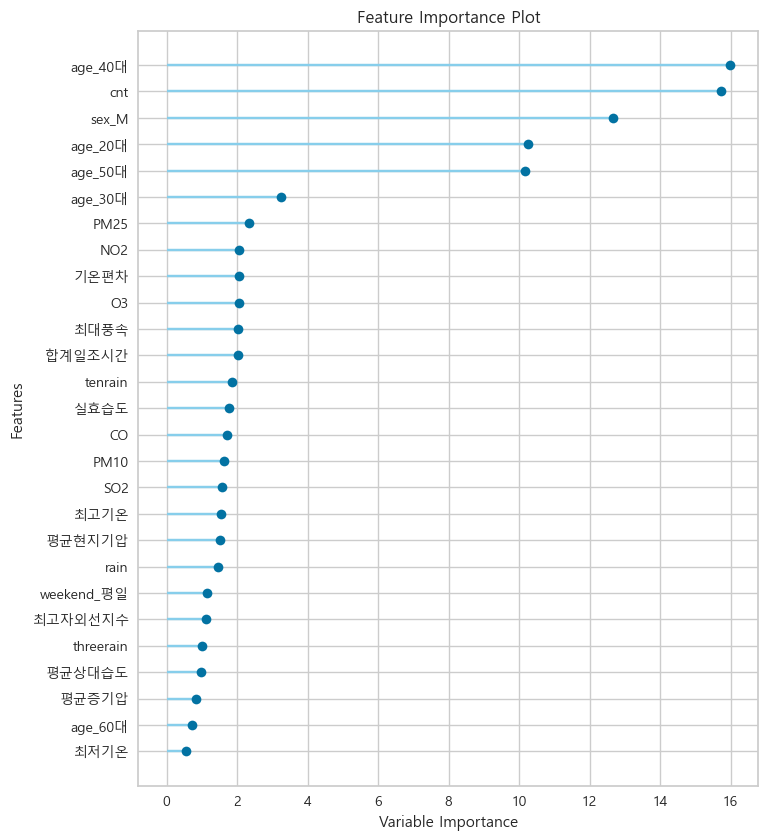

In [41]:
# 피쳐 중요도 확인
plot_model(model_01, 'feature_all' )

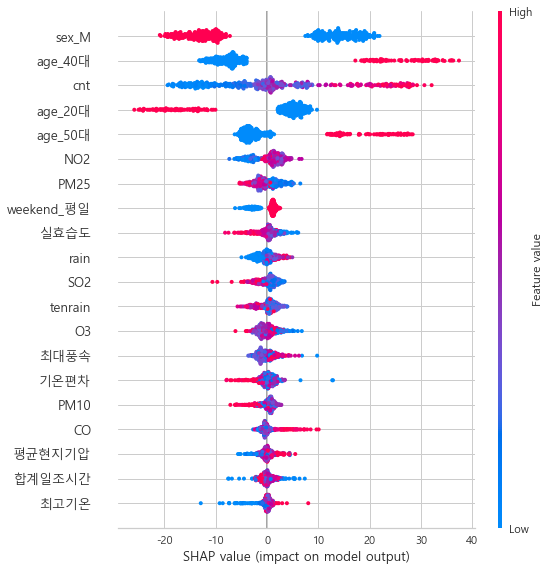

In [42]:
# Shap 확인 
interpret_model(model_01)

In [43]:
interpret_model(model_01, plot = 'reason', observation = 100)